In [1]:
#check hardware
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10738286477581813358
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3667263488
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2324832083769897865
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [2]:
#import libraries
import pandas as pd
from datasets import Dataset
import seaborn as sns
import matplotlib.pyplot as plt

D:\Anaconda3\envs\aml2gpu\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#file path
path_img = './Stage_I/img'
path_dat = './dataset'
path_fil = '/clean_extended_train.csv'
#parameters
LEN_CONS = 60

In [4]:
raw_data = pd.read_csv(path_dat + path_fil)
#drop duplicate review
raw_data.drop_duplicates(subset = 'review', inplace = True)
#print dataset basic information
print(raw_data.shape[0])
print(raw_data.columns.values)
print(raw_data['rating'].unique())

1536627
['review' 'rating']
[5 4 1 3 2]


In [5]:
task1_data = raw_data.copy()
#follow the BERT input label format
#0 stands for negative, 1 stands for positive
task1_data.loc[task1_data['rating']<=3,'rating'] = 0
task1_data.loc[task1_data['rating']>=4,'rating'] = 1
#clear empty value
complete_data = task1_data.dropna().reindex()
#select data whose length is below LEN_CONS
mask = (complete_data['review'].str.len() <= LEN_CONS)
mask_data = complete_data.loc[mask]
#show rating distribution
mask_data['rating'].value_counts()

1    464859
0     51557
Name: rating, dtype: int64

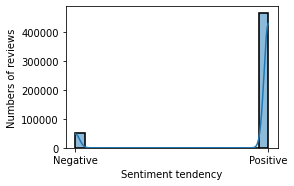

In [6]:
#distribution plot of samples
fig,ax = plt.subplots(figsize = (3.8,2.6))
plt.rcParams['font.size'] = 9.7

ax.set_xlabel("Sentiment tendency")
ax.set_ylabel("Numbers of reviews")

ax.set_xticks([0,1])
ax.set_xticks([0,1])
ax.set_xticklabels(['Negative','Positive'])
sns.histplot(mask_data['rating'], kde=True, ax = ax, linewidth = 1.6)
plt.savefig(path_img+'/'+'distribution'+'.png')
plt.savefig(path_img+'/'+'distribution'+'.svg')

In [7]:
#form a smaller dataset
#original ratio
data_0 = mask_data.loc[mask_data['rating'] == 0].head(2000)
data_1 = mask_data.loc[mask_data['rating'] == 1].head(18000)
minor_data_ori = pd.concat([data_0, data_1])
#balanced ratio
data_0 = mask_data.loc[mask_data['rating'] == 0].head(10000)
data_1 = mask_data.loc[mask_data['rating'] == 1].head(10000)
minor_data_bal = pd.concat([data_0, data_1])

In [8]:
#show distribution
distribution = minor_data_ori['review'].str.len().astype(int)
distribution.describe().apply(lambda x: format(x, 'f'))

count    20000.000000
mean        40.184000
std         14.441765
min          1.000000
25%         29.000000
50%         42.000000
75%         54.000000
max         60.000000
Name: review, dtype: object

D:\Anaconda3\envs\aml2gpu\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


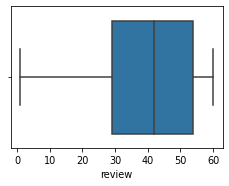

In [9]:
#boxplot
import seaborn as sns

fig,ax = plt.subplots(figsize = (3.8,2.6))
plt.rcParams['font.size'] = 9.7

ax = sns.boxplot(distribution)
plt.savefig(path_img+'/'+'dist_box_ori'+'.png')
plt.savefig(path_img+'/'+'dist_box_ori'+'.svg')

In [10]:
#show distribution
distribution = minor_data_bal['review'].str.len().astype(int)
distribution.describe().apply(lambda x: format(x, 'f'))

count    20000.000000
mean        38.810000
std         14.424621
min          1.000000
25%         27.000000
50%         40.000000
75%         52.000000
max         60.000000
Name: review, dtype: object

D:\Anaconda3\envs\aml2gpu\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


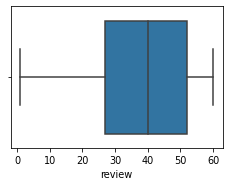

In [11]:
#boxplot
import seaborn as sns

fig,ax = plt.subplots(figsize = (3.8,2.6))
plt.rcParams['font.size'] = 9.7

ax = sns.boxplot(distribution)
plt.savefig(path_img+'/'+'dist_box_bal'+'.png')
plt.savefig(path_img+'/'+'dist_box_bal'+'.svg')

In [12]:
def model_initialization(MODEL = 'bert-base-uncased'):
    #model import
    import tensorflow as tf
    from transformers import TFAutoModelForSequenceClassification
    model = TFAutoModelForSequenceClassification.from_pretrained(MODEL, num_labels=2)
    return model

In [13]:
def model_train(model,model_name,tf_train_dataset,tf_validation_dataset,dataset_name,PARAMETERS):
    import tensorflow as tf
    from transformers import AdamWeightDecay
    from transformers import WarmUp
    #parameters
    EPOCH       = PARAMETERS[0]#6
    ILR         = PARAMETERS[1]#5e-5
    D_S         = PARAMETERS[2]#600
    D_R         = PARAMETERS[3]#0.9
    W_S         = PARAMETERS[4]#200

    #define callback function
    train_los = []
    train_acc = []

    test_los = []
    test_acc = []

    class CustomCallback(tf.keras.callbacks.Callback):
        def on_train_batch_end(self, batch, logs=None):
            keys = list(logs.keys())
            train_los.append(logs['loss'])
            train_acc.append(logs['sparse_categorical_accuracy'])

        def on_test_batch_end(self, batch, logs=None):
            keys = list(logs.keys())
            test_los.append(logs['loss'])
            test_acc.append(logs['sparse_categorical_accuracy'])
    
    #training
    #define scheduler with warmup
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=ILR,
        decay_steps=D_S,
        decay_rate=D_R)
    #warmup mechanism
    scheduler = WarmUp(initial_learning_rate=ILR,warmup_steps=W_S,decay_schedule_fn=lr_schedule)
    sch_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

    #define adamW optimizer
    AdamW = AdamWeightDecay(scheduler)#learning_rate=ILR)

    model.compile(
        optimizer=AdamW,#tf.keras.optimizers.Adam(learning_rate=5e-5),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=tf.metrics.SparseCategoricalAccuracy()
    )
    #callback
    callbacks = [tf.keras.callbacks.TensorBoard(log_dir='callback',update_freq=100,histogram_freq=100),CustomCallback()]#,sch_callback]
    #training
    history = model.fit(tf_train_dataset, validation_data=tf_validation_dataset, epochs=EPOCH, callbacks = callbacks)
    
    #save acc and loss information
    curve = [train_los,train_acc,test_los,test_acc]
    #save model
    #model.save_weights('./Stage_I/weight/'+model_name+dataset_name+'weights')
    return history,curve

In [14]:
#model training pipline
def train_pipline(minor_data,dataset_name,model_name = 'bert-base-uncased'):
    #train test dataset split
    dataset_data = Dataset.from_pandas(minor_data)
    dataset_split = dataset_data.train_test_split(test_size=0.2)

    #parameters
    dataset = dataset_split
    MODEL = model_name

    EPOCH       = 2
    ILR         = 5e-5
    D_S         = 600
    D_R         = 0.9
    W_S         = 200

    PARAMETERS = [EPOCH,ILR,D_S,D_R,W_S]

    #################################
    #tokenization                   #
    #################################
    from transformers import AutoTokenizer
    tokenizer = AutoTokenizer.from_pretrained(MODEL)

    def tokenize_function(examples):
        return tokenizer(examples['review'], padding="max_length", max_length=64, truncation=True)
    tokenized_datasets = dataset.map(tokenize_function, batched=True)
    #################################
    #train/test dataset conversion  #
    #################################
    train_dataset = tokenized_datasets["train"].shuffle(seed=1)
    eval_dataset = tokenized_datasets["test"].shuffle(seed=1)

    from transformers import DefaultDataCollator
    data_collator = DefaultDataCollator(return_tensors="tf")

    tf_train_dataset = train_dataset.to_tf_dataset(
        columns=["attention_mask", "input_ids", "token_type_ids"],
        label_cols=["rating"],
        shuffle=True,
        collate_fn=data_collator,
        batch_size=16,
    )

    tf_validation_dataset = eval_dataset.to_tf_dataset(
        columns=["attention_mask", "input_ids", "token_type_ids"],
        label_cols=["rating"],
        shuffle=False,
        collate_fn=data_collator,
        batch_size=8,
    )
    #################################
    #model init and training        #
    #################################

    #model initialization
    model = model_initialization(MODEL=MODEL)
    #model training
    history,curve = model_train(model,MODEL,tf_train_dataset,tf_validation_dataset,dataset_name,PARAMETERS)
    #check the accuracy curve
    #print(history.params)
    #print(history.history.keys())

    return model,curve,tf_validation_dataset,eval_dataset

In [15]:
#result analysis
def result_analysis(model,tf_validation_dataset,eval_dataset,name):
    from sklearn.metrics import classification_report
    import pandas as pd
    import numpy as np
    #prediction based on trained model
    predict = model.predict(tf_validation_dataset)

    Y_test = eval_dataset['rating']
    y_pred = np.argmax(predict.logits,axis = 1)
    #precision recall f1 socre of each category
    report = classification_report(Y_test, y_pred)
    #open text file
    text_file = open('./Stage_I/report/'+name+'.txt', "w")
    #write string to file
    text_file.write(report)
    #close file
    text_file.close()

    #heatmap
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    cm = confusion_matrix(Y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)

    fig,ax = plt.subplots(figsize = (3.8,2.6))
    plt.rcParams['font.size'] = 9.7

    disp.plot(ax=ax)
    plt.savefig(path_img+'/'+name+'_conmat'+'.png')
    plt.savefig(path_img+'/'+name+'_conmat'+'.svg')
    pass

In [16]:
#draw curve
def learn_curve(data,name):
    fig,ax1 = plt.subplots(figsize = (3.8,2.6))
    plt.rcParams['font.size'] = 9.7

    loss1 = data[0]
    acc1  = data[1]
    loss2 = data[2]
    acc2  = data[3]

    ax1.set_xlabel("Learning Curve")
    ax1.set_ylabel("Loss")

    ax2 = ax1.twinx()
    ax2.set_ylabel("Acc")

    ax1.plot(loss1, linewidth = 1.6)
    ax1.plot(loss2, linewidth = 1.6)
    ax2.plot(acc1 , linewidth = 1.6)
    ax2.plot(acc2 , linewidth = 1.6)
    plt.savefig(path_img+'/'+name+'_lecur'+'.png')
    plt.savefig(path_img+'/'+name+'_lecur'+'.svg')
    pass

In [17]:
def model_dataset_choose(code):
    if   code == 0:
        #original ratio dataset using BERT
        mod_ori_bert,cur_ori_bert,val__ori_bert,eva_ori_bert = train_pipline(minor_data_ori,'ori','bert-base-uncased')
        result_analysis(mod_ori_bert,val__ori_bert,eva_ori_bert,'bert_ori')
        learn_curve(cur_ori_bert,'ori'+'bert-base-uncased')
    elif code == 1:
        #balance ratio dataset using BERT
        mod_bal_bert,cur_bal_bert,val__bal_bert,eva_bal_bert = train_pipline(minor_data_bal,'bal','bert-base-uncased')
        result_analysis(mod_bal_bert,val__bal_bert,eva_bal_bert,'bert_bal')
        learn_curve(cur_bal_bert,'bal'+'bert-base-uncased')
    elif code == 2:
        #original ratio dataset using RoBERTa
        mod_ori_roberta,cur_ori_roberta,val__ori_roberta,eva_ori_roberta = train_pipline(minor_data_ori,'ori','roberta-base')
        result_analysis(mod_ori_roberta,val__ori_roberta,eva_ori_roberta,'roberta_ori')
        learn_curve(cur_ori_roberta,'ori'+'roberta-base')
    elif code == 3:
        #balance ratio dataset using RoBERTa
        mod_bal_roberta,cur_bal_roberta,val__bal_roberta,eva_bal_roberta = train_pipline(minor_data_bal,'bal','roberta-base')
        result_analysis(mod_bal_roberta,val__bal_roberta,eva_bal_roberta,'roberta_bal')
        learn_curve(cur_bal_roberta,'bal'+'roberta-base')
    pass

100%|██████████| 4/4 [00:00<00:00, 20.40ba/s]
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
1000/1000 [==============================] - 275s 260ms/step - loss: 0.3919 - sparse_categorical_accuracy: 0.8309 - val_loss: 0.3348 - val_sparse_categorical_accuracy: 0.8612
Epoch 2/2
1000/1000 [==============================] - 259s 258ms/step - loss: 0.3013 - sparse_categorical_accuracy: 0.8856 - val_loss: 0.3354 - val_sparse_categorical_accuracy: 0.8677


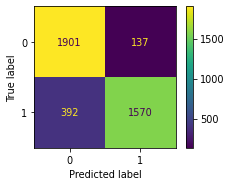

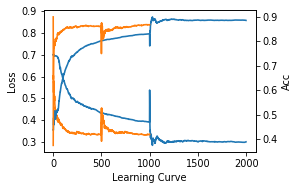

In [18]:
model_dataset_choose(3)